# How does the SFF method work?

Vanderburg and Johnson (2014) introduced a method for "Self Flat Fielding" by tracking how the lightcurve changes with motion of the spacecraft:

[A Technique for Extracting Highly Precise Photometry for the Two-Wheeled Kepler Mission](http://adsabs.harvard.edu/abs/2014PASP..126..948V)

In this notebook we replicate the K2SFF method following the same example source, #60021426, as that in the publication.  We aim to demystify the technique, which is extremely popular within the K2 community.  We have focused on reproducibility, so that we achieve the same result at the publication.

The Vanderburg & Johnson 2014 paper uses data from the Kepler two-wheel "Concept Engineering Test", predating campaign 0, and sometimes called campaign *"eng"* or abbreviated CET.  This vestigal "campaign" lacks some of the standardization of later K2 campaigns--- it was much shorter, only about 9 days long, it lacks some of the standard quality flags, targets have non-traditional EPIC IDs, and other quirks.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd

## Retrieve the K2SFF data for ENG test source `60021426`

First we will retrieve data and inspect the mask used in the paper.

In [4]:
path = 'http://archive.stsci.edu/hlsps/k2sff/cet/060000000/21426/hlsp_k2sff_k2_lightcurve_060021426-cet_kepler_v1_llc.fits'
vdb_fits = fits.open(path)

The `BESTAPER` keyword explains which aperture was chosen as the "best" by Vanderburg & Johnson 2014.  The FITS header for that slice contains the metadata needed to reproduce the mask.

In [5]:
keys = ['MASKTYPE', 'MASKINDE', 'NPIXSAP']
_ = [print(key, ' : ', vdb_fits['BESTAPER'].header[key]) for key in keys]

MASKTYPE  :  PRF FIT
MASKINDE  :  4
NPIXSAP  :  29.0


We want the *exact same* mask as Vanderburg & Johnson 2014, but the publication version and MAST version differ!

Publication version:
![img](https://www.cfa.harvard.edu/~avanderb/k2/ep60021426image.png)

MAST Version:
![MAST Version](http://archive.stsci.edu/hlsps/k2sff/cet/060000000/21426/hlsp_k2sff_k2_lightcurve_060021426-cet_kepler_v1_image.png)

Aperture 7 should yield a bigger mask, more similar to what was used in the paper.

In [6]:
VDB_J_mask = vdb_fits['PRF_APER_TBL'].data[7,:, :] == True
VDB_J_mask.sum()

53

Save the mask for easy use in our next notebook.

In [7]:
np.save('VDB_J_2014_mask.npy', VDB_J_mask)

## Manually reproduce with the Vanderburg-provided diagnostic data
Retrieve the Vanderburg-provided diagnostic data for the Kepler ENG testing.  
Uncomment the line below to retrieve the data programmatically, or manually get the linked file in a browser and save it to this directory.

In [8]:
#! wget https://www.cfa.harvard.edu/~avanderb/k2/ep60021426alldiagnostics.csv

In [9]:
df = pd.read_csv('ep60021426alldiagnostics.csv',index_col=False)
df.head()

,BJD - 2454833,Raw Flux,Corrected Flux,X-centroid,Y-centroid,arclength,Correction,Thrusters On
0,1862.502368,0.995119,0.995985,25.135097,24.661074,2.327480,0.999130,1.0
1,1862.522801,0.997313,0.996767,25.289752,24.418689,1.175322,1.000548,1.0
2,1862.543235,0.996713,0.996136,25.288052,24.429406,1.214627,1.000580,0.0
3,1862.563668,0.996930,0.996277,25.275216,24.448405,1.306617,1.000656,0.0
4,1862.584102,0.996862,0.996228,25.253864,24.480184,1.460259,1.000636,0.0


We can mean-subtract the provided $x-y$ centroids, assigning them column and row identifiers, then rotate the coordinates into their major and minor axes.

In [10]:
col = df[' X-centroid'].values
col = col - np.mean(col)
row = df[' Y-centroid'].values 
row = row - np.mean(row)

In [11]:
def _get_eigen_vectors(centroid_col, centroid_row):
    '''get the eigenvalues and eigenvectors given centroid x, y positions'''
    centroids = np.array([centroid_col, centroid_row])
    eig_val, eig_vec = np.linalg.eigh(np.cov(centroids))
    return eig_val, eig_vec

In [12]:
def _rotate(eig_vec, centroid_col, centroid_row):
    '''rotate the centroids into their predominant linear axis'''
    centroids = np.array([centroid_col, centroid_row])
    return np.dot(eig_vec, centroids)

In [13]:
eig_val, eig_vec = _get_eigen_vectors(col, row)
v1, v2 = eig_vec

The major axis is the latter.

In [14]:
platescale = 4.0 # The Kepler plate scale; has units of arcseconds / pixel

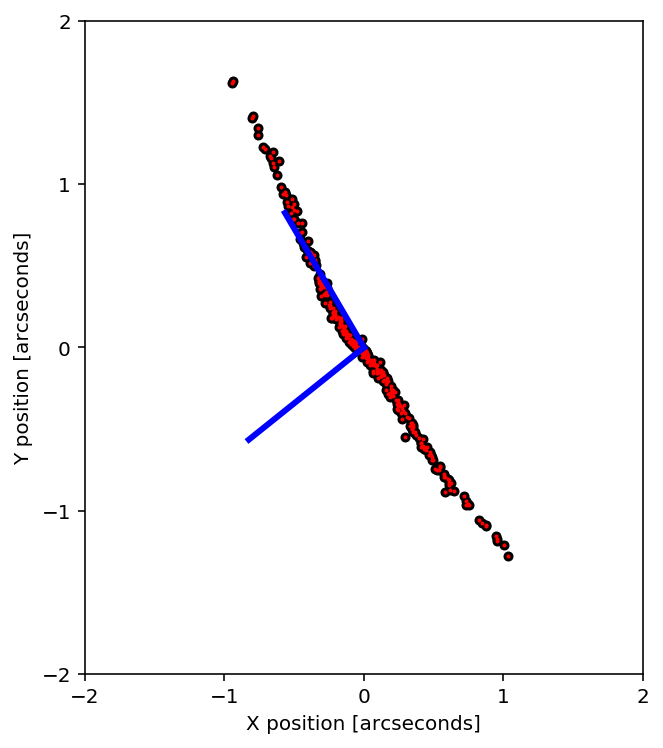

In [15]:
plt.figure(figsize=(5, 6))
plt.plot(col * platescale, row * platescale, 'ko', ms=4)
plt.plot(col * platescale, row * platescale, 'ro', ms=1)
plt.xticks([-2, -1,0, 1, 2])
plt.yticks([-2, -1,0, 1, 2])
plt.xlabel('X position [arcseconds]')
plt.ylabel('Y position [arcseconds]')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot([0, v1[0]], [0, v1[1]], color='blue', lw=3)
plt.plot([0, v2[0]], [0, v2[1]], color='blue', lw=3);

Following the form of **Figure 2** of Vanderburg & Johsnon 2014.

In [16]:
rot_colp, rot_rowp = _rotate(eig_vec, col, row) #units in pixels

You can rotate into the new reference frame.

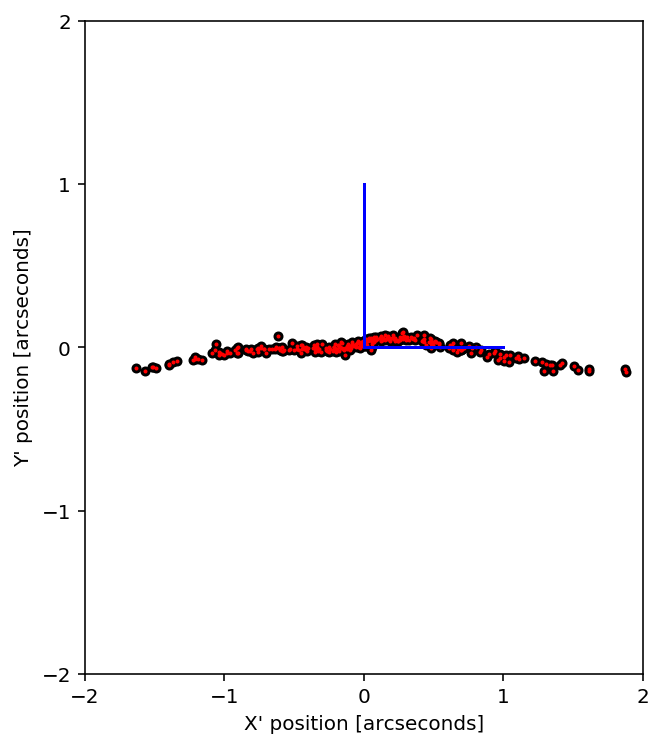

In [17]:
plt.figure(figsize=(5, 6))
plt.plot(rot_rowp * platescale, rot_colp * platescale, 'ko', ms=4)
plt.plot(rot_rowp * platescale, rot_colp * platescale, 'ro', ms=1)
plt.xticks([-2, -1,0, 1, 2])
plt.yticks([-2, -1,0, 1, 2])
plt.xlabel("X' position [arcseconds]")
plt.ylabel("Y' position [arcseconds]")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot([0, 1], [0, 0], color='blue')
plt.plot([0, 0], [0, 1], color='blue');

We need to calculate the arclength using:
\begin{equation}s= \int_{x'_0}^{x'_1}\sqrt{1+\left( \frac{dy'_p}{dx'}\right)^2} dx'\end{equation}

where $x^\prime_0$ is the transformed $x$ coordinate of the point with the smallest $x^\prime$ position, and $y^\prime_p$ is the best--fit polynomial function.

Fit a $5^{th}$ order polynomial to the rotated coordinates.

In [18]:
z = np.polyfit(rot_rowp, rot_colp, 5)
p5 = np.poly1d(z)
p5_deriv = p5.deriv()

In [19]:
x0_prime = np.min(rot_rowp)
xmax_prime = np.max(rot_rowp)
x_dense = np.linspace(x0_prime, xmax_prime, 2000)

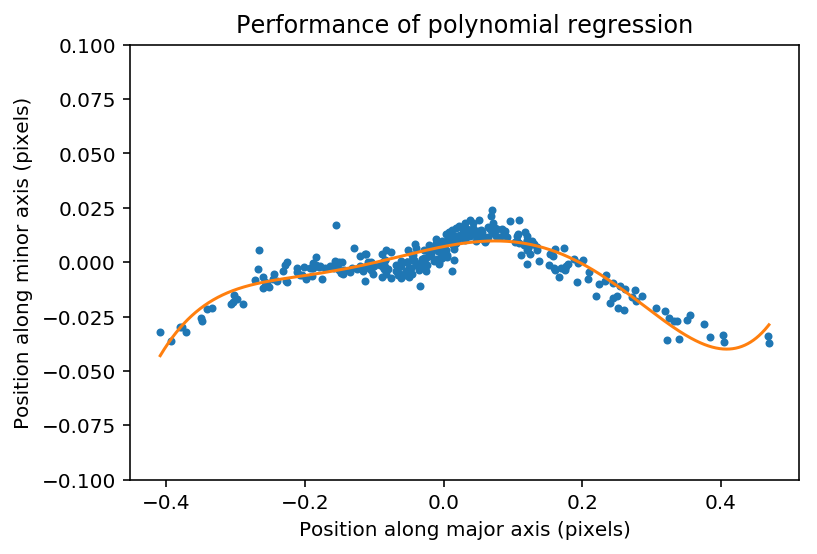

In [20]:
plt.plot(rot_rowp, rot_colp, '.')
plt.plot(x_dense, p5(x_dense))
plt.ylabel('Position along minor axis (pixels)')
plt.xlabel('Position along major axis (pixels)')
plt.title('Performance of polynomial regression')
plt.ylim(-0.1, 0.1);

We see evidence for a [bias-variance tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff), suggesting some modest opportunity for improvement.

In [21]:
@np.vectorize
def arclength(x):
    '''Input x1_prime, get out arclength'''
    gi = x_dense <x
    s_integrand = np.sqrt(1 + p5_deriv(x_dense[gi]) ** 2)
    s = np.trapz(s_integrand, x=x_dense[gi])
    return s

Let's double check that we compute the same arclength as the published paper.

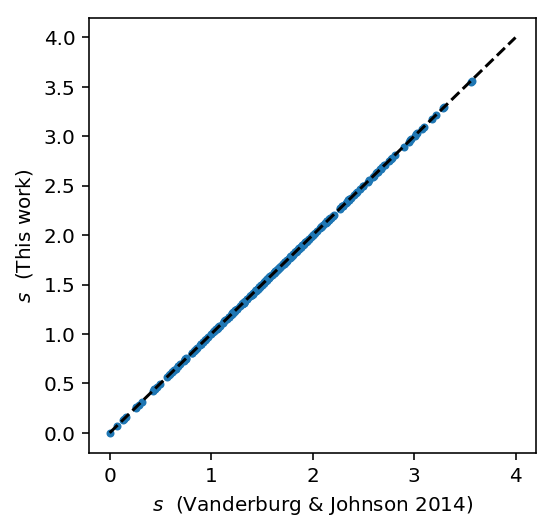

In [22]:
aspect_ratio = plt.figaspect(1)
plt.figure(figsize=aspect_ratio)
plt.plot(df[' arclength'], arclength(rot_rowp)*4.0, '.')
plt.xlabel('$s$  (Vanderburg & Johnson 2014)')
plt.ylabel('$s$  (This work)')
plt.plot([0, 4], [0, 4], 'k--');

Yes, we compute arclength correctly.

Now we apply a **high-pass filter** to the raw lightcurve data.  We follow the original paper by using *BSplines* with 1.5 day breakpoints.  You can also apply data exclusion at this stage.

In [23]:
from scipy.interpolate import BSpline
from scipy import interpolate

In [24]:
times, raw_fluxes = df['BJD - 2454833'].values, df[' Raw Flux'].values

We find the weighted least square spline for a given set of knots, $t$.  We supply interior knots as knots on the ends are added automatically, as stated in the `interpolate.splrep()` docstring.

In [25]:
interior_knots = np.arange(times[0]+1.5, times[0]+6, 1.5)
t,c,k = interpolate.splrep(times, raw_fluxes, s=0, task=-1, t=interior_knots)
bspl = BSpline(t,c,k)

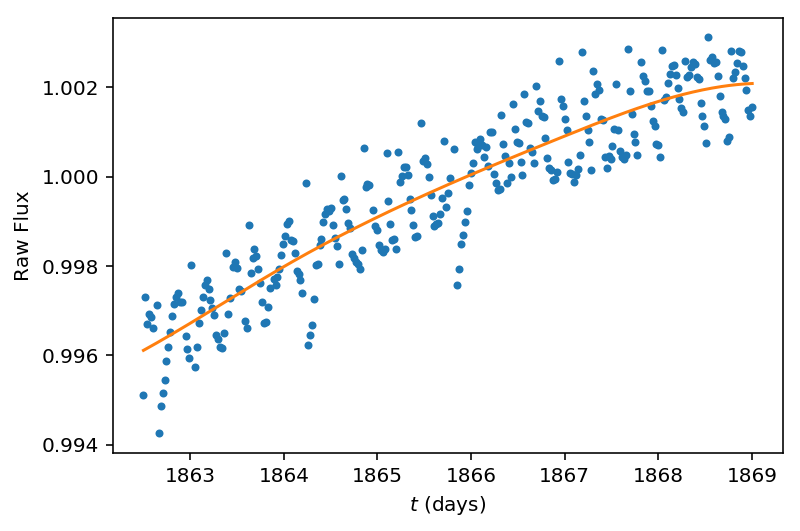

In [26]:
plt.plot(times, raw_fluxes, '.')
plt.plot(times, bspl(times))
plt.xlabel('$t$ (days)')
plt.ylabel('Raw Flux');

The Spline fit looks good, so we can normalize the flux by the long-term trend.  
Plot the normalized flux versus arclength to see the position-dependent flux.

In [27]:
fluxes = raw_fluxes/bspl(times)

Mask the data by keeping only the good samples.

In [28]:
bi = df[' Thrusters On'].values == 1.0
gi = df[' Thrusters On'].values == 0.0
clean_fluxes = fluxes[gi]
al = arclength(rot_rowp[gi]) * platescale

In [29]:
sorted_inds = np.argsort(al)

We will follow the paper by interpolating **flux versus arclength position** in 15 bins of means, which is a *piecewise linear fit*.

In [30]:
knots = np.array([np.min(al)]+ 
                 [np.median(splt) for splt in np.array_split(al[sorted_inds], 15)]+
                 [np.max(al)])

In [31]:
bin_means = np.array([clean_fluxes[sorted_inds][0]]+
                     [np.mean(splt) for splt in np.array_split(clean_fluxes[sorted_inds], 15)]+
                     [clean_fluxes[sorted_inds][-1]])

In [32]:
zz = np.polyfit(al, clean_fluxes,6)
sff = np.poly1d(zz)
al_dense = np.linspace(0, 4, 1000)
interp_func = interpolate.interp1d(knots, bin_means)

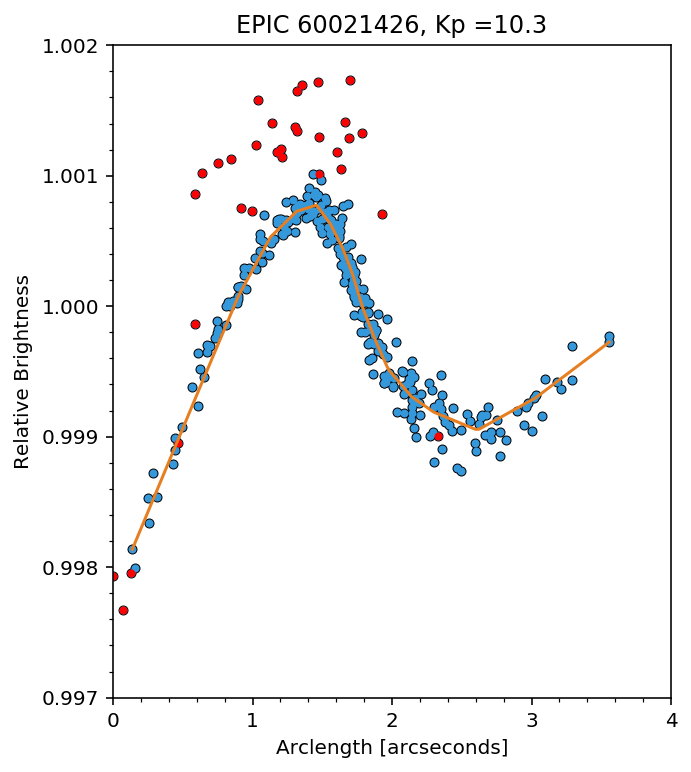

In [33]:
plt.figure(figsize=(5, 6))
plt.plot(arclength(rot_rowp)*4.0, fluxes, 'ko', ms=4)
plt.plot(arclength(rot_rowp)*4.0, fluxes, 'o', color='#3498db', ms=3)
plt.plot(arclength(rot_rowp[bi])*4.0, fluxes[bi], 'o', color='r', ms=3)
plt.plot(np.sort(al), interp_func(np.sort(al)), '-', color='#e67e22')

plt.xticks([0, 1,2, 3, 4])
plt.minorticks_on()
plt.xlabel('Arclength [arcseconds]')
plt.ylabel('Relative Brightness')
plt.title('EPIC 60021426, Kp =10.3')
plt.xlim(0,4)
plt.ylim(0.997, 1.002);

Following **Figure 4** of Vanderburg & Johnson 2014.

Apply the Self Flat Field (SFF) correction:

In [34]:
corr_fluxes = clean_fluxes / interp_func(al)

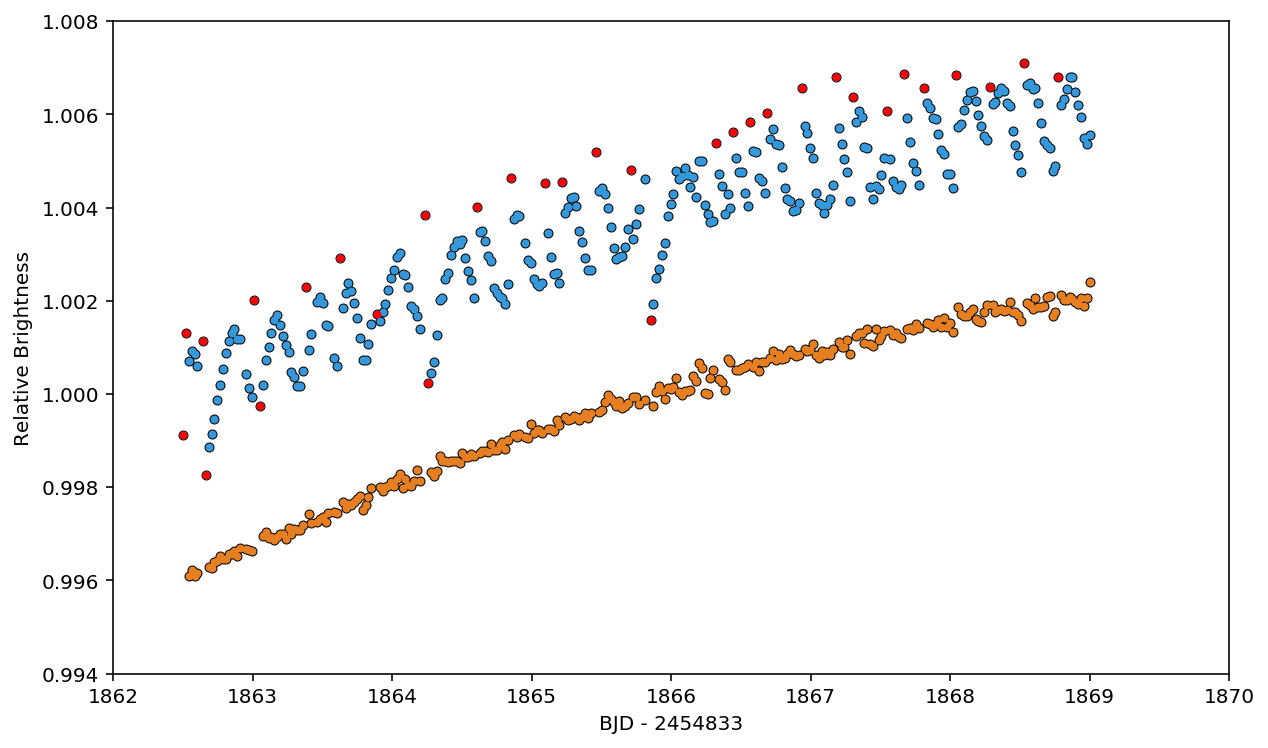

In [35]:
plt.figure(figsize=(10,6))

dy = 0.004
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'ko', ms=4)
plt.plot(df['BJD - 2454833'], df[' Raw Flux']+dy, 'o', color='#3498db', ms=3)
plt.plot(df['BJD - 2454833'][bi], df[' Raw Flux'][bi]+dy, 'o', color='r', ms=3)
plt.plot(df['BJD - 2454833'][gi], corr_fluxes*bspl(times[gi]), 'o', color='k', ms = 4)
plt.plot(df['BJD - 2454833'][gi], corr_fluxes*bspl(times[gi]), 'o', color='#e67e22', ms = 3)

plt.xlabel('BJD - 2454833')
plt.ylabel('Relative Brightness')

plt.xlim(1862, 1870)
plt.ylim(0.994, 1.008);

Following **Figure 5** of Vanderburg & Johnson 2015.

*The end.*